In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import time
import itertools
import h5py

import numpy as np
import multiprocessing as mp
from scipy.stats import norm
from scipy.stats import expon

import matplotlib.pyplot as plt
import matplotlib.cm as cm

import seaborn as sns
sns.set(style="ticks", color_codes=True, font_scale=1.5)
sns.set_style({"xtick.direction": "in", "ytick.direction": "in"})

In [2]:
import cossio
import kinetics

In [3]:
def pmf2d(xq, qk):
    H, x_edges, y_edges = np.histogram2d(data[:,1],data[:,2], \
            bins=[np.linspace(-12,12,100), np.linspace(-12,12,100)])

    fig, ax = plt.subplots(figsize=(6,5))
    pmf = -np.log(H.transpose())
    pmf -= np.min(pmf)
    #pmf = np.max(pmf) - pmf 
    cs = ax.contourf(pmf, extent=[x_edges.min(), x_edges.max(), \
                     y_edges.min(), y_edges.max()], \
                     cmap=cm.rainbow, levels=np.arange(0, 8,0.5))
    #pmf = -np.log(counts.transpose())

    
    #cs = ax.contourf(counts.transpose()) #, \
            #extent=[xbins.min(), xbins.max(), ybins.min(), ybins.max()], \
            #cmap=cm.rainbow, levels=np.arange(0,10 ,1))
    cbar = plt.colorbar(cs)
    ax.set_xlim(-12,12)
    ax.set_ylim(-12,12)
    ax.set_xlabel('$x$', fontsize=20)
    ax.set_ylabel('$q$', fontsize=20)
    plt.tight_layout()

In [4]:
def calc_rates(y):
    lifeA, lifeB = kinetics.calc_life([y])
    meanA = 1./np.exp(np.mean(np.log([x for x in lifeA if x>0])))
    meanB = 1./np.exp(np.mean(np.log([x for x in lifeB if x>0])))
    errorA = meanA/np.sqrt(len(lifeA))
    errorB = meanA/np.sqrt(len(lifeB))
    return np.mean([meanA, meanB]), np.mean([errorA, errorB])

In [5]:
def cossio_runner(inp):
    np.random.seed()
    kl = inp[0]
    sc = inp[1]
    numsteps = inp[2]
    
    Dq = sc*Dx
    x, q = [5., 5.]

    tt, xk, qk = cossio.run_brownian(x0=x, barrier=5., kl=kl, \
                            Dx=Dx, Dq=Dq, numsteps=numsteps, \
                                     fwrite=int(1./dt))
    data = np.column_stack((tt,xk,qk))

    h5file = "data/cossio_kl%g_Dx%g_Dq%g.h5"%(kl, Dx, Dq)
    with h5py.File(h5file, "w") as hf:
        hf.create_dataset("data", data=data)

    return h5file

In [6]:
# Globals
dt = 5e-4
Dx = 1. # Diffusion coefficient for molecular coordinate

### Molecular potential of mean force 

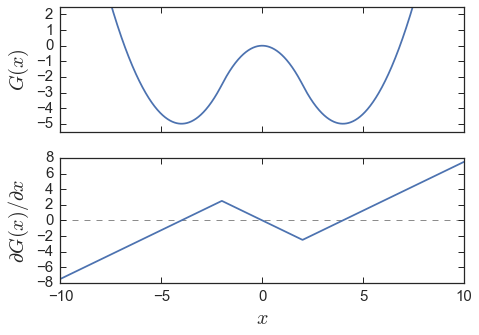

In [7]:
x = np.linspace(-10,10,1000)
fig, ax = plt.subplots(2,1, figsize=(7,5), sharex=True)
Gx = [cossio.Gx(y, barrier=5.) for y in x]
dGqxdx = [cossio.dGqxdx(0, y, barrier=5.) for y in x]
ax[0].plot(x, Gx)
ax[0].set_ylabel('$G(x)$', fontsize=20)
ax[0].set_ylim(-1.1*5,0.5*5)

ax[1].plot(x, dGqxdx)
ax[1].set_xlabel('$x$', fontsize=20)
ax[1].set_ylabel('$\partial G(x)/\partial x$', fontsize=20)
ax[1].hlines(0, -10, 10, linestyle='dashed', linewidth=0.5)

#ax[2].set_ylabel('$\partial^2 G(x)/\partial x^2$', fontsize=20)

plt.tight_layout()

### Diffusion on molecular coordinate

In [285]:
start = time.time()
x, q = [5., 0.]
t, xk, qk = cossio.run_brownian(x0=x, barrier=5., kl=0., \
                             Dx=Dx, numsteps=int(1e7), fwrite=int(1./dt))
end = time.time()
print end - start

21.5922541618


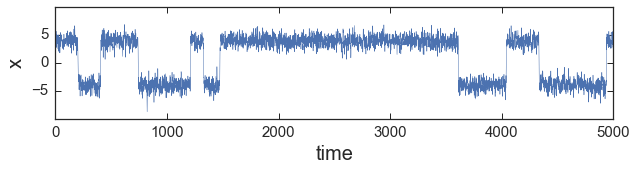

In [286]:
fig, ax = plt.subplots(figsize=(10,2))
ax.plot(xk, linewidth=0.5)
ax.set_ylim(-10,10)
ax.set_yticks([-5.,0,5.])
ax.set_xlabel('time', fontsize=20)
ax.set_ylabel('x', fontsize=20)

In [287]:
rate0 = np.array(calc_rates(xk))
print rate0

[ 0.00296876  0.00139968]


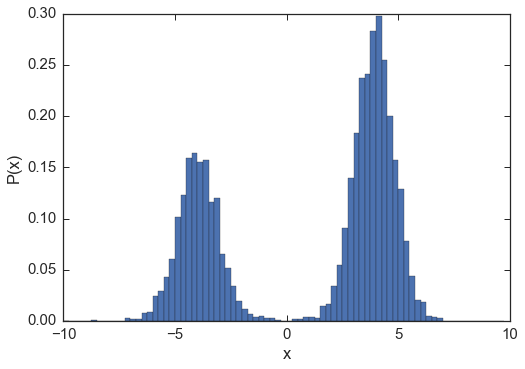

In [288]:
fig, ax = plt.subplots()
hist, bin_edges, patches = \
        ax.hist(xk, bins=np.arange(-10,10,0.25), normed=True)
ax.set_ylabel('P(x)')
ax.set_xlabel('x')

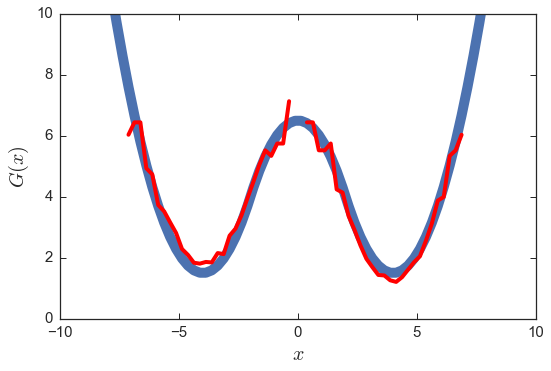

In [289]:
bin_centers = [0.5*(bin_edges[i]+bin_edges[i+1]) \
               for i in range(len(bin_edges)-1)]
fig, ax = plt.subplots()
ax.plot(bin_centers, [cossio.Gx(x) + 6.5   for x in bin_centers], lw=10)
ax.plot(bin_centers, -np.log(hist), 'red', lw=4)
ax.set_ylabel('$G(x)$', fontsize=20)
ax.set_xlabel('$x$', fontsize=20)
ax.set_ylim(0,10)
plt.tight_layout()

In [94]:
sc = [50, 20, 10, 5, 2, 1, 0.5, 0.2, 0.1, 0.05, 0.02, 0.01, 0.005, 0.002, 0.001]
kl = [0.63, 1.3]
froot = "data/cossio_kl%g_Dx1_Dq%g.h5"

data/cossio_kl0_Dx1_Dq0.h5


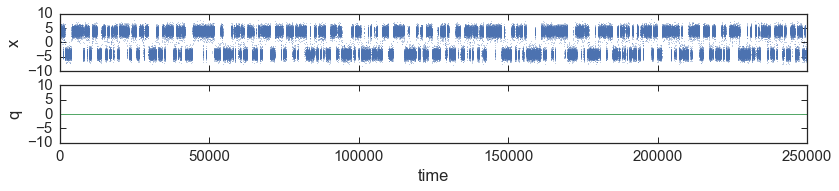

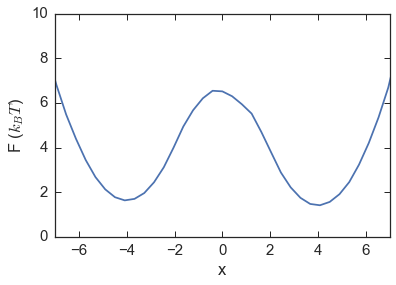

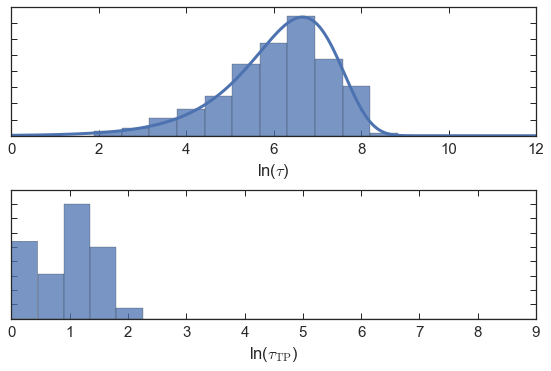

In [261]:
h5file = "data/cossio_kl0_Dx1_Dq0.h5"

print h5file
f = h5py.File(h5file, 'r')
data = np.array(f['data'])
f.close()

fig, ax = plt.subplots(2,1,figsize=(12,3), sharex=True,sharey=True)
ax[0].plot(data[:,0],data[:,1],'.', markersize=1)
ax[1].plot(data[:,0],data[:,2],'g.', markersize=1)
ax[1].set_ylim(-10,10)
ax[1].set_xlim(0,25e4)
ax[0].set_ylabel('x')
ax[1].set_ylabel('q')
ax[1].set_xlabel('time')
plt.tight_layout(h_pad=0)

fig, ax = plt.subplots(figsize=(6,4))
hist, bin_edges = np.histogram(data[:,1], bins=np.linspace(-10,10,50), normed=True)
bin_centers = [0.5*(bin_edges[i]+bin_edges[i+1]) \
               for i in range(len(bin_edges)-1)]
ax.plot(bin_centers, -np.log(hist))
ax.set_xlim(-7,7)
ax.set_ylim(0,10)
ax.set_xlabel('x')
ax.set_ylabel('F ($k_BT$)')

tau_f, tau_u, data_f, data_u, tp_f, tp_u, recrossings = \
        kinetics.lifetimes(data, f_bound=-4, u_bound=4)
       
tpt_u = []
tpt_f = []
for td in tp_u:
    try:
        tpt_u.append(td[:,0][-1] - td[:,0][0])
    except IndexError:
        pass
for td in tp_f:
    try:
        tpt_f.append(td[:,0][-1] - td[:,0][0])
    except IndexError:
        pass

fig, ax = plt.subplots(2,1)
histogram, bin_edges, patches = \
        ax[0].hist(np.log(tau_f + tau_u), \
                   bins=np.linspace(0,12,20), \
                   normed=True, cumulative=False, alpha=0.75)

param = expon.fit([tau_f + tau_u], floc=0)
rate0 = param[1]

lx = np.linspace(0,12,200)
pdf = 1/param[1]*np.exp(lx)*np.exp(-1/param[1]*(np.exp(lx)))
ax[0].plot(lx, pdf, lw=3, color='b')
    
histogram, bin_edges, patches = \
        ax[1].hist(np.log([x/2. for x in (tpt_f + tpt_u) if x > 0]), \
                   bins=np.linspace(0,9,21), \
                   normed=True, cumulative=False, alpha=0.75)

tpt0 = np.mean([x/2. for x in (tpt_f + tpt_u) if x > 0])
ax[0].set_yticklabels([])
ax[1].set_yticklabels([])
ax[0].set_xlabel(r'ln($\tau$)')
ax[1].set_xlabel(r'ln($\tau_\mathrm{TP}$)')
    
plt.tight_layout(h_pad=0.5, w_pad=0)

data/cossio_kl0.63_Dx1_Dq50.h5


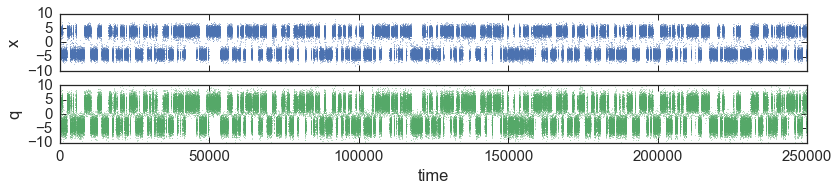

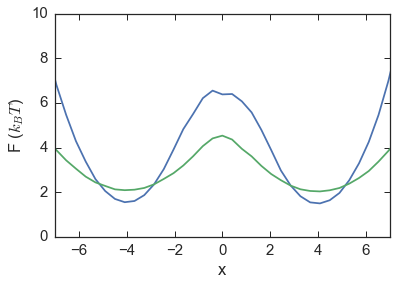

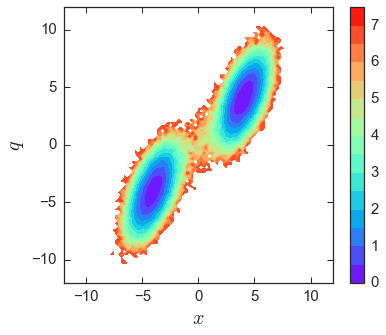

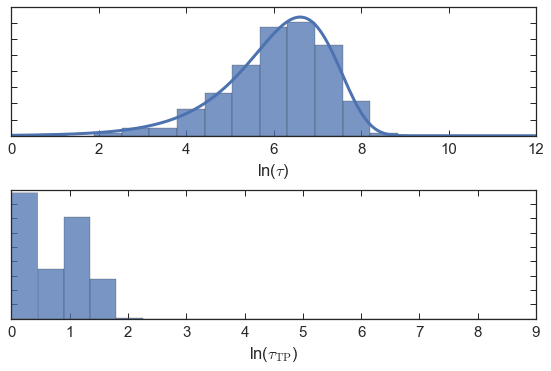

In [95]:
h5file = froot%(kl[0],sc[0])
print h5file
f = h5py.File(h5file, 'r')
data = np.array(f['data'])
f.close()

fig, ax = plt.subplots(2,1,figsize=(12,3), sharex=True,sharey=True)
ax[0].plot(data[:,0],data[:,1],'.', markersize=1)
ax[1].plot(data[:,0],data[:,2],'g.', markersize=1)
ax[1].set_ylim(-10,10)
ax[1].set_xlim(0,25e4)
ax[0].set_ylabel('x')
ax[1].set_ylabel('q')
ax[1].set_xlabel('time')
plt.tight_layout(h_pad=0)

fig, ax = plt.subplots(figsize=(6,4))
hist, bin_edges = np.histogram(data[:,1], bins=np.linspace(-10,10,50), normed=True)
bin_centers = [0.5*(bin_edges[i]+bin_edges[i+1]) \
               for i in range(len(bin_edges)-1)]
ax.plot(bin_centers, -np.log(hist))
hist, bin_edges = np.histogram(data[:,2], bins=np.linspace(-10,10,50), normed=True)
bin_centers = [0.5*(bin_edges[i]+bin_edges[i+1]) \
               for i in range(len(bin_edges)-1)]
ax.plot(bin_centers, -np.log(hist))
ax.set_xlim(-7,7)
ax.set_ylim(0,10)
ax.set_xlabel('x')
ax.set_ylabel('F ($k_BT$)')

pmf2d(data[:,1], data[:,2])

tau_f, tau_u, data_f, data_u, tp_f, tp_u, recrossings = \
        kinetics.lifetimes(data[:,[0,2]], f_bound=-4, u_bound=4)
       
tpt_u = []
tpt_f = []
for td in tp_u:
    try:
        tpt_u.append(td[:,0][-1] - td[:,0][0])
    except IndexError:
        pass
for td in tp_f:
    try:
        tpt_f.append(td[:,0][-1] - td[:,0][0])
    except IndexError:
        pass

fig, ax = plt.subplots(2,1)
histogram, bin_edges, patches = \
        ax[0].hist(np.log(tau_f + tau_u), \
                   bins=np.linspace(0,12,20), \
                   normed=True, cumulative=False, alpha=0.75)

param = expon.fit([tau_f + tau_u], floc=0)
rate0 = param[1]

lx = np.linspace(0,12,200)
pdf = 1/param[1]*np.exp(lx)*np.exp(-1/param[1]*(np.exp(lx)))
ax[0].plot(lx, pdf, lw=3, color='b')
    
histogram, bin_edges, patches = \
        ax[1].hist(np.log([x/2. for x in (tpt_f + tpt_u) if x > 0]), \
                   bins=np.linspace(0,9,21), \
                   normed=True, cumulative=False, alpha=0.75)

tpt0 = np.mean([x/2. for x in (tpt_f + tpt_u) if x > 0])
ax[0].set_yticklabels([])
ax[1].set_yticklabels([])
ax[0].set_xlabel(r'ln($\tau$)')
ax[1].set_xlabel(r'ln($\tau_\mathrm{TP}$)')
    
plt.tight_layout(h_pad=0.5, w_pad=0)


0 data/cossio_kl0.63_Dx1_Dq50.h5
1 data/cossio_kl0.63_Dx1_Dq10.h5
2 data/cossio_kl0.63_Dx1_Dq5.h5
3 data/cossio_kl0.63_Dx1_Dq1.h5
4 data/cossio_kl0.63_Dx1_Dq0.5.h5
5 data/cossio_kl0.63_Dx1_Dq0.1.h5
6 data/cossio_kl0.63_Dx1_Dq0.05.h5
7 data/cossio_kl0.63_Dx1_Dq0.01.h5
8 data/cossio_kl0.63_Dx1_Dq0.005.h5
9 data/cossio_kl0.63_Dx1_Dq0.001.h5


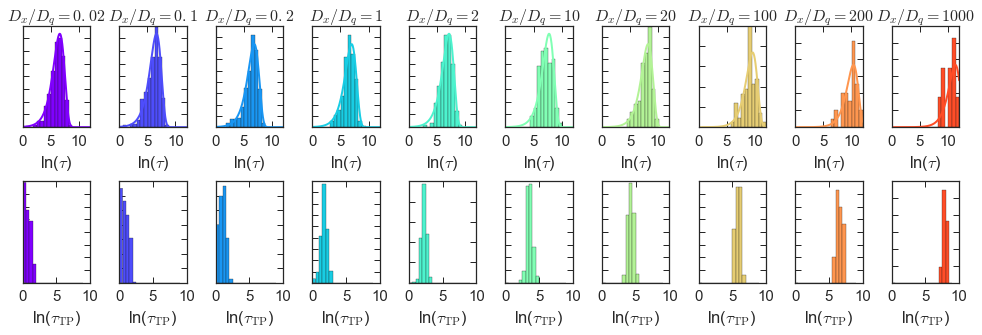

In [284]:
from scipy.stats import expon

i = 0
sc_sel = [50,10,5,1,0.5,0.1,0.05, 0.01, 0.005, 0.001]
lsc = len(sc_sel)

fig, ax = plt.subplots(2,lsc,figsize=(14,5))
ax = ax.flatten()
for s in sc_sel:
    h5file = froot%(kl[0], s)
    print i, h5file
    f = h5py.File(h5file, 'r')
    data = np.array(f['data'])
    f.close()
    
    data = np.array(data[:,[0,2]])
    tau_f, tau_u, data_f, data_u, tp_f, tp_u, recrossings = \
        kinetics.lifetimes(data, f_bound=-4, u_bound=4)
       
    tpt_u = []
    tpt_f = []
    for td in tp_u:
        try:
            tpt_u.append(td[:,0][-1] - td[:,0][0])
        except IndexError:
            pass
    for td in tp_f:
        try:
            tpt_f.append(td[:,0][-1] - td[:,0][0])
        except IndexError:
            pass

    histogram, bin_edges, patches = \
        ax[i].hist(np.log(tau_f + tau_u), \
                   bins=np.linspace(0,12,20), \
                   normed=True, cumulative=False, color=plt.cm.rainbow(float(i)/lsc))

    param = expon.fit([tau_f + tau_u], floc=0)
    lx = np.linspace(0,12,200)
    pdf = 1/param[1]*np.exp(lx)*np.exp(-1/param[1]*(np.exp(lx)))
    ax[i].plot(lx, pdf, color=plt.cm.rainbow(float(i)/lsc), lw=2)
    ax[i].set_title('$D_x/D_q=%g$'%(1./s), fontsize=16)
    
    
    histogram, bin_edges, patches = \
        ax[i+lsc].hist(np.log([x/2. for x in (tpt_f + tpt_u) if x > 0]), \
                   bins=np.linspace(0,9,19), \
                   normed=True, cumulative=False, color=plt.cm.rainbow(float(i)/lsc))
    i +=1

for i in range(lsc):
    ax[i].set_yticklabels([])
    ax[i+lsc].set_yticklabels([])
    ax[i].set_xticks(range(0,15,5))
    ax[i+lsc].set_xticks(range(0,15,5))

for i in range(lsc):
    ax[i].set_xlabel(r'ln($\tau$)')
    ax[i+lsc].set_xlabel(r'ln($\tau_\mathrm{TP}$)')
    
plt.tight_layout(h_pad=0.5, w_pad=0)

data/cossio_kl0.63_Dx1_Dq50.h5
data/cossio_kl0.63_Dx1_Dq10.h5
data/cossio_kl0.63_Dx1_Dq5.h5
data/cossio_kl0.63_Dx1_Dq1.h5
data/cossio_kl0.63_Dx1_Dq0.5.h5
data/cossio_kl0.63_Dx1_Dq0.1.h5
data/cossio_kl0.63_Dx1_Dq0.05.h5
data/cossio_kl0.63_Dx1_Dq0.01.h5
data/cossio_kl0.63_Dx1_Dq0.005.h5
data/cossio_kl0.63_Dx1_Dq0.001.h5


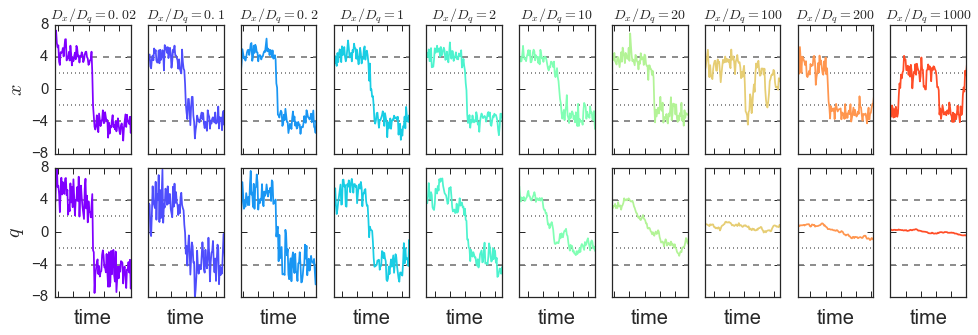

In [277]:
fig, ax = plt.subplots(2,lsc,figsize=(14,5), sharey=True)
ax = ax.flatten()
for a in ax:
    a.axhline(4, 0, 1e4, c='gray', ls='dashed')
    a.axhline(-4, 0, 1e4, c='gray', ls='dashed')
    a.axhline(-2, 0, 1e4, c='gray', ls='dotted')
    a.axhline(2, 0, 1e4, c='gray', ls='dotted')

i = 0

for s in sc_sel:
    h5file = froot%(kl[0],s)
    print h5file
    f = h5py.File(h5file, 'r')
    data = np.array(f['data'])
    f.close()
    
    _, _, _, _, tp_f, tp_u, _ = \
        kinetics.lifetimes(data, f_bound=-4, u_bound=4)
    ib = tp_u[1][0,0]
    ie = tp_u[1][-1,0]
    im = int((ie+ib)/2)
    ax[i].plot(data[im-100:im+100,0],data[im-100:im+100,1], color=plt.cm.rainbow(float(i)/lsc))
    ax[i].set_title('$D_x/D_q=%g$'%(1./s), fontsize=14)

    ax[i+lsc].plot(data[im-100:im+100,0],data[im-100:im+100,2], color=plt.cm.rainbow(float(i)/lsc))
    #ax[i].plot(data[:,0], data[:,1], color=plt.cm.rainbow(i/7.))
    #ax[i+lsc].plot(data[:,0], data[:,2], color=plt.cm.rainbow(i/7.))
    
#    ax[i].set_xticks(np.arange(0,1e5,50))
#    ax[i+8].set_xticks(np.arange(0,1e5,50))
    ax[i].set_xlim(im-50,im+50)
    ax[i+lsc].set_xlim(im-50,im+50)
    i+=1

ax[0].set_ylim(-8,8)
ax[0].set_yticks([-8,-4, 0, 4, 8])
for i in range(lsc*2):
    ax[i].set_xticklabels([])
ax[0].set_ylabel(r'$x$', fontsize=20)
ax[lsc].set_ylabel(r'$q$', fontsize=20)
for i in range(lsc, 2*lsc):
    ax[i].set_xlabel('time', fontsize=20)
plt.tight_layout(h_pad=0, w_pad=0)

In [102]:
tau = {}
tau_error = {}
tpt = {}
tpt_error = {}
for k in kl:
    tau[k] = []
    tau_error[k] = []

    tpt[k] = []
    tpt_error[k] = []

    for s in sc:
        print s
        h5file = froot%(k,s)
        print h5file
        f = h5py.File(h5file, 'r')
        data = np.array(f['data'])
        f.close()
    
        data = np.array(data[:,[0,2]])
        tau_f, tau_u, data_f, data_u, tp_f, tp_u, recrossings = \
            kinetics.lifetimes(data, f_bound=-4, u_bound=4)
       
        tpt_u = []
        tpt_f = []
        for td in tp_u:
            try:
                tpt_u.append(td[:,0][-1] - td[:,0][0])
            except IndexError:
                pass
        for td in tp_f:
            try:
                tpt_f.append(td[:,0][-1] - td[:,0][0])
            except IndexError:
                pass

        param = expon.fit([tau_f + tau_u], floc=0)
        tau[k].append(param[1])
        tau_error[k].append(param[1]/np.sqrt(len(tau_f + tau_u)))
    
        tpt[k].append(np.mean([x/2. for x in (tpt_f + tpt_u) if x > 0]))
        tpt_error[k].append(tpt[k][-1]/np.sqrt(len([x/2. for x in (tpt_f + tpt_u) if x > 0])))

50
data/cossio_kl0.63_Dx1_Dq50.h5
20
data/cossio_kl0.63_Dx1_Dq20.h5
10
data/cossio_kl0.63_Dx1_Dq10.h5
5
data/cossio_kl0.63_Dx1_Dq5.h5
2
data/cossio_kl0.63_Dx1_Dq2.h5
1
data/cossio_kl0.63_Dx1_Dq1.h5
0.5
data/cossio_kl0.63_Dx1_Dq0.5.h5
0.2
data/cossio_kl0.63_Dx1_Dq0.2.h5
0.1
data/cossio_kl0.63_Dx1_Dq0.1.h5
0.05
data/cossio_kl0.63_Dx1_Dq0.05.h5
0.02
data/cossio_kl0.63_Dx1_Dq0.02.h5
0.01
data/cossio_kl0.63_Dx1_Dq0.01.h5
0.005
data/cossio_kl0.63_Dx1_Dq0.005.h5
0.002
data/cossio_kl0.63_Dx1_Dq0.002.h5
0.001
data/cossio_kl0.63_Dx1_Dq0.001.h5
50
data/cossio_kl1.3_Dx1_Dq50.h5
20
data/cossio_kl1.3_Dx1_Dq20.h5
10
data/cossio_kl1.3_Dx1_Dq10.h5
5
data/cossio_kl1.3_Dx1_Dq5.h5
2
data/cossio_kl1.3_Dx1_Dq2.h5
1
data/cossio_kl1.3_Dx1_Dq1.h5
0.5
data/cossio_kl1.3_Dx1_Dq0.5.h5
0.2
data/cossio_kl1.3_Dx1_Dq0.2.h5
0.1
data/cossio_kl1.3_Dx1_Dq0.1.h5
0.05
data/cossio_kl1.3_Dx1_Dq0.05.h5
0.02
data/cossio_kl1.3_Dx1_Dq0.02.h5
0.01
data/cossio_kl1.3_Dx1_Dq0.01.h5
0.005
data/cossio_kl1.3_Dx1_Dq0.005.h5
0.002
data/co

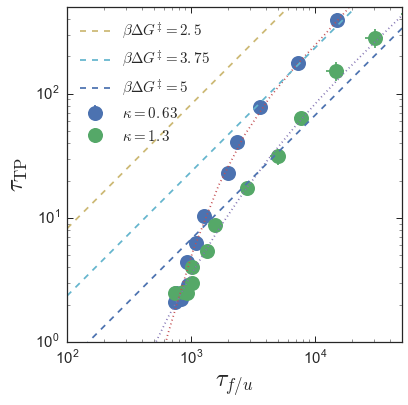

In [281]:
fig, ax = plt.subplots(figsize=(6,6))
for k in kl:
    ax.errorbar(tau[k], tpt[k], xerr=tau_error[k], yerr=tpt_error[k], \
                fmt='o', ms=15, label="$\kappa=%g$"%k)
    
for k in kl:
    z = np.polyfit(np.log(tau[k][:-1]),np.log(tpt[k][:-1]), 3)
    x = np.linspace(6,15,20)
    vals = np.poly1d(z)(x)
    ax.plot(np.exp(x),np.exp(vals), ls='dotted')
    
ax.plot(np.logspace(2,5,20), 0.082*np.logspace(2,5,20), \
        '--' , label=r'$\beta \Delta G^\ddag=%g$'%2.5)
ax.plot(np.logspace(2,5,20), 0.0235*np.logspace(2,5,20), \
        '--' , label=r'$\beta  \Delta G^\ddag=%g$'%3.75)
ax.plot(np.logspace(2,5,20), 0.00672*np.logspace(2,5,20), \
        '--' , label=r'$\beta  \Delta G^\ddag=%g$'%5)
ax.set_xlim(1e2,5e4)
ax.set_ylim(1e0,5e2)
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend(loc=2)
ax.set_ylabel(r'$\tau_\mathrm{TP}$', fontsize=24)
ax.set_xlabel(r'$\tau_{f/u}$', fontsize=24)

In [257]:
np.exp(-3.75)

0.023517745856009107

In [180]:
print np.logspace(6,15,20)

[  1.00000000e+06   2.97635144e+06   8.85866790e+06   2.63665090e+07
   7.84759970e+07   2.33572147e+08   6.95192796e+08   2.06913808e+09
   6.15848211e+09   1.83298071e+10   5.45559478e+10   1.62377674e+11
   4.83293024e+11   1.43844989e+12   4.28133240e+12   1.27427499e+13
   3.79269019e+13   1.12883789e+14   3.35981829e+14   1.00000000e+15]


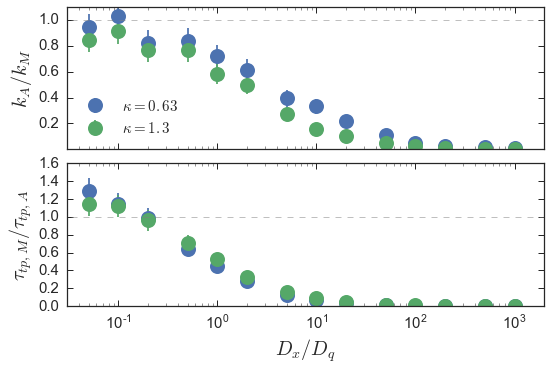

In [280]:
fig, ax = plt.subplots(2,1, sharex=True)
for k in kl:
    ax[0].errorbar(1./np.array(sc), rate0/np.array(tau[k]), \
                   yerr=2*(rate0/tau[k]-rate0/(np.array(tau[k])+np.array(tau_error[k]))), \
                   fmt='o', ms=15, label="$\kappa=%g$"%k)
    ax[1].errorbar(1./np.array(sc), tpt0/np.array(tpt[k]), \
                   yerr=2*(tpt0/tpt[k]-tpt0/(np.array(tpt[k])+np.array(tpt_error[k]))), \
                   fmt='o', ms=15)
    
ax[0].set_xlim(3e-2,2000)
ax[0].set_ylim(2e-4,1.1)
ax[0].set_xscale('log')
#ax[1].set_yscale('log')
ax[0].axhline(1,1e-2,1e3, ls='dashed', c='gray',lw=0.5)
ax[1].axhline(1,1e-2,1e3, ls='dashed', c='gray',lw=0.5)
ax[1].set_xlabel('$D_x/D_q$', fontsize=20)
ax[0].set_ylabel('$k_A/k_M$', fontsize=20)
ax[1].set_ylabel(r'$\tau_{tp,M}/\tau_{tp,A}$', fontsize=20)
#ax[0].set_yscale('log')
ax[0].legend(loc=3)
plt.tight_layout(h_pad=0)

(0, 7)

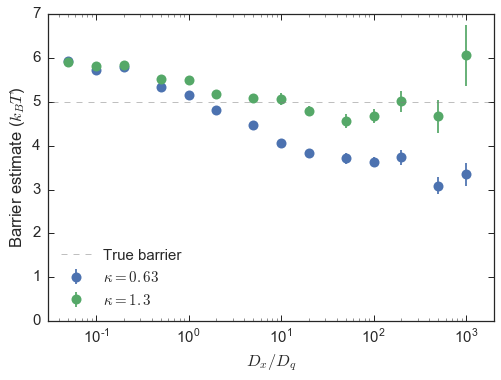

In [208]:
fig, ax = plt.subplots()
for k in kl:
    ax.errorbar(1./np.array(sc), -np.log(np.array(tpt[k])/np.array(tau[k])),\
            -np.log(np.array(tpt[k])/np.array(tau[k])) + np.log((np.array(tpt[k]) \
            +np.array(tpt_error[k]))/np.array(tau[k])), \
            fmt='o', ms=10, label="$\kappa=%g$"%k)
ax.set_xscale('log')
ax.set_xlabel('$D_x/D_q$')
ax.set_ylabel('Barrier estimate ($k_BT$)')
ax.axhline(5, 1e-2, 1e3, ls='dashed', lw=0.5, color='gray', label='True barrier')
ax.legend(loc=3)
ax.set_xlim(3e-2,2000)
ax.set_ylim(0,7)

(0, 7)

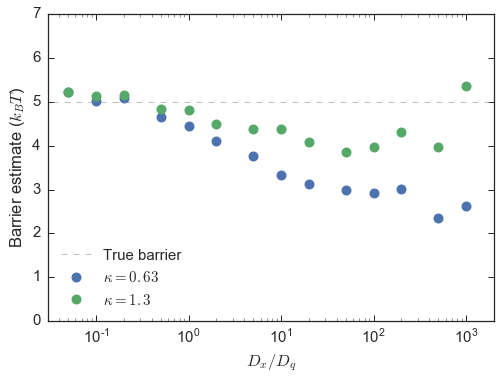

In [267]:
fig, ax = plt.subplots()
for k in kl:
    ax.errorbar(1./np.array(sc), np.log(1./2*(np.array(tau[k])/np.array(tpt[k]) - 1.)),\
            fmt='o', ms=10, label="$\kappa=%g$"%k)
ax.set_xscale('log')
ax.set_xlabel('$D_x/D_q$')
ax.set_ylabel('Barrier estimate ($k_BT$)')
ax.axhline(5, 1e-2, 1e3, ls='dashed', lw=0.5, color='gray', label='True barrier')
ax.legend(loc=3)
ax.set_xlim(3e-2,2000)
ax.set_ylim(0,7)

In [274]:
print (0.5**2)/(tpt0*rate0)

0.000111947189402


In [275]:
rate0


781.25000000000136